In [ ]:
!pip install -q torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.8 MB/s eta 0:00:00


Saving 2269e7be-9238-4093-845b-2759f52a0209.jpeg to 2269e7be-9238-4093-845b-2759f52a0209 (2).jpeg
Inference Time: 8.9895 seconds


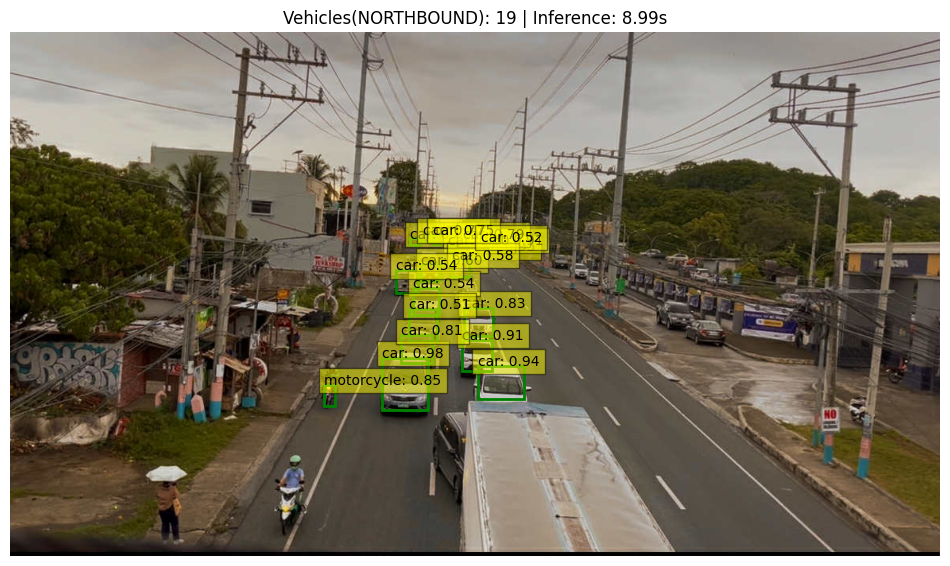

Vehicle breakdown (NORTHBOUND):
Car: 18
Truck: 0
Motorcycle: 1
Total vehicles: 19


In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import time

# COCO class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush','tomato'
]

# 📤 Upload image
uploaded = files.upload()
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

# 🔄 Convert to tensor
img_tensor = F.to_tensor(img)

# 🎯 Load model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# ⏱️ Run inference
start_time = time.time()
with torch.no_grad():
    pred = model([img_tensor])[0]
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

# 📐 Get image dimensions
# 📐 Get image dimensions
img_width, img_height = img.size
left_limit = img_width * 0.45# 40% from left
right_limit = img_width * 0.55# 60% from left


# 🧮 Vehicle type counters
vehicle_counts = {
    "car": 0,
    "truck": 0,
    "motorcycle": 0
}

# 🖼️ Display results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i in range(len(pred['boxes'])):
    score = pred['scores'][i].item()
    if score > 0.5:
        label_idx = pred['labels'][i].item()
        label = COCO_INSTANCE_CATEGORY_NAMES[label_idx]

        if label in vehicle_counts:
            box = pred['boxes'][i].numpy()
            x1, y1, x2, y2 = box
            x_center = (x1 + x2) / 2

            # ✅ Only include vehicles from the left and middle
            if x_center < right_limit:
                vehicle_counts[label] += 1

                # 📦 Shrink the bounding box by 20%
                shrink_factor = 0.2
                box_width = x2 - x1
                box_height = y2 - y1
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2

                new_width = box_width * (1 - shrink_factor)
                new_height = box_height * (1 - shrink_factor)
                x1 = cx - new_width / 2
                x2 = cx + new_width / 2
                y1 = cy - new_height / 2
                y2 = cy + new_height / 2

                ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='green', facecolor='none'))
                ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=10,
                        bbox=dict(facecolor='yellow', alpha=0.5))

# 🧾 Summary
total_detected = sum(vehicle_counts.values())
title_str = f"Vehicles(NORTHBOUND): {total_detected} | Inference: {inference_time:.2f}s"
plt.title(title_str)
plt.axis('off')
plt.show()

# 📊 Print breakdown
print("Vehicle breakdown (NORTHBOUND):")
for vehicle, count in vehicle_counts.items():
    print(f"{vehicle.title()}: {count}")
print(f"Total vehicles: {total_detected}")


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 📤 Load image (replace with your uploaded file path if needed)
uploaded = files.upload()
file_name = next(iter(uploaded))
image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
_, thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)

# 🔍 Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
    x, y, w, h = cv2.boundingRect(approx)

    if len(approx) == 3:
        shape_name = "Triangle"
        color = (0, 255, 0)
    elif len(approx) == 4:
        aspect_ratio = float(w) / h
        shape_name = "Square" if 0.95 <= aspect_ratio <= 1.05 else "Rectangle"
        color = (255, 0, 0)
    elif len(approx) > 4:
        shape_name = "Circle"
        color = (0, 0, 255)
    else:
        continue

    cv2.drawContours(image, [approx], -1, color, 2)
    cv2.putText(image, shape_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# 🖼️ Convert BGR to RGB and show
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Shapes")
plt.show()


NameError: name 'files' is not defined

In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
model = fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")  # updated usage instead of deprecated pretrained=True
model.eval()



FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Download the image from the web
!wget -q https://upload.wikimedia.org/wikipedia/commons/4/4c/Push_van_cat.jpg -O cat.jpg

# Now load and process it
from PIL import Image
import torchvision.transforms as T
import torch

# Open the downloaded image
image = Image.open('cat.jpg').convert("RGB")

# Transform the image to a tensor
transform = T.ToTensor()
img_tensor = transform(image)


In [ ]:
with torch.no_grad():
    prediction = model([img_tensor])

# Display results
print(prediction)

[{'boxes': tensor([[1.0870e+02, 3.8881e+01, 7.7341e+02, 6.0000e+02],
        [0.0000e+00, 1.1447e+01, 7.1220e+02, 5.0817e+02],
        [0.0000e+00, 7.7935e+00, 3.9278e+02, 3.4493e+02],
        [0.0000e+00, 2.0967e+00, 6.6954e+02, 4.5946e+02],
        [0.0000e+00, 4.1945e+00, 4.4616e+02, 3.5204e+02],
        [0.0000e+00, 5.9143e+00, 6.4474e+02, 5.2520e+02],
        [4.9853e+02, 9.4750e+01, 7.7612e+02, 5.8415e+02],
        [0.0000e+00, 5.6244e-01, 4.5026e+02, 3.3161e+02],
        [0.0000e+00, 1.6430e+02, 8.0000e+02, 6.0000e+02],
        [0.0000e+00, 8.7433e-02, 4.2687e+02, 3.2861e+02]]), 'labels': tensor([17,  3, 62, 72,  3, 62, 17, 28, 65, 72]), 'scores': tensor([0.9866, 0.1324, 0.0952, 0.0948, 0.0909, 0.0870, 0.0773, 0.0730, 0.0673,
        0.0556])}]


In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
    'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A',
    'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
    'hair drier', 'toothbrush'
]

In [ ]:
def draw_boxes(img_tensor, prediction, threshold=0.5):
    img = img_tensor.cpu().permute(1, 2, 0).numpy()

    plt.imshow(img)
    ax = plt.gca()

    for box, score, label in zip(prediction[0]['boxes'],
                                 prediction[0]['scores'],
                                 prediction[0]['labels']):
        if score > threshold:
            box = box.cpu().numpy()
            x0, y0, x1, y1 = box
            class_name = COCO_INSTANCE_CATEGORY_NAMES[label.item()]
            ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                       fill=False, edgecolor='red', linewidth=2))
            ax.text(x0, y0, f'{class_name}: {score:.2f}',
                    bbox=dict(facecolor='yellow', alpha=0.5), fontsize=10)

    plt.axis('off')
    plt.show()

In [ ]:
import time

start_time = time.time()

with torch.no_grad():
    prediction = model([img_tensor])

end_time = time.time()
inference_time = end_time - start_time

print(f"Inference time: {inference_time:.3f} seconds")

draw_boxes(img_tensor, prediction)